In [1]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
import wradlib.ipol as ipol
%matplotlib inline

In [2]:
data = h5py.File("../../data/data.h5", mode="r")  # "data.h5" (mode r)
#data = h5py.File("/Users/jiang/data/")
# dictionary structure: {"t": [ [t-24, t-23,..., t-1], [t+1,...,t+12] ]}
eval_idx = np.load("../../data/eval_dict.npy",allow_pickle=True).item()

In [3]:
eval_instance = eval_idx
data_instance = data
model = models.Dense()

if True:
    key = sorted(list(eval_instance.keys()))[0]    
#for key in sorted(list(eval_instance.keys())):
    inputs = np.array([ data_instance[key][:] for key in eval_instance[key][0] ])  # (24, 900, 900)
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)

/Users/jiang/anaconda3/envs/rainymotion/lib/python3.7/site-packages/wradlib/ipol.py:368: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p


In [4]:
inputs.shape

(24, 900, 900)

In [5]:
self = model

### Dense

In [7]:
def _advection_constant_vector(of_instance, lead_steps=12):
    delta_x = of_instance[::, ::, 0]
    delta_y = of_instance[::, ::, 1]
    # make a source meshgrid
    coord_source_i, coord_source_j = np.meshgrid(range(of_instance.shape[1]),range(of_instance.shape[0]))

    # calculate new coordinates of radar pixels
    coord_targets = []
    for lead_step in range(lead_steps):
        coord_target_i = coord_source_i + delta_x * (lead_step + 1)
        coord_target_j = coord_source_j + delta_y * (lead_step + 1)
        coord_targets.append([coord_target_i, coord_target_j])

    coord_source = [coord_source_i, coord_source_j]
    return coord_source, coord_targets
def _interpolator(points, coord_source, coord_target, method="idw"):
    # _interpolator(self.input_data[-1], coord_source,coord_targets[lead_step],method=self.interpolation))
    coord_source_i, coord_source_j = coord_source
    coord_target_i, coord_target_j = coord_target
    # reshape
    trg = np.vstack((coord_source_i.ravel(), coord_source_j.ravel())).T
    src = np.vstack((coord_target_i.ravel(), coord_target_j.ravel())).T

    if method == "nearest":
        interpolator = NearestNDInterpolator(src, points.ravel(),tree_options={"balanced_tree": False})
        points_interpolated = interpolator(trg)
    elif method == "linear":
        interpolator = LinearNDInterpolator(src, points.ravel(), fill_value=0)
        points_interpolated = interpolator(trg)
    elif method == "idw":
        interpolator = ipol.Idw(src, trg)
        points_interpolated = interpolator(points.ravel())

    # reshape output
    points_interpolated = points_interpolated.reshape(points.shape)

    return points_interpolated.astype(points.dtype)

In [19]:
import sys
sys.version

'3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) \n[Clang 9.0.1 ]'

In [21]:
data_scaled.shape

(24, 900, 900)

In [8]:
import skimage.transform as sktf
import cv2

# scale input data to uint8 [0-255] with self.scaler
data_scaled, c1, c2 = self.scaler(self.input_data) # shape (24, 900, 900)

self.advection = "constant-vector"
self.of_method = "DIS"
direction = "backward"
data_instance = data_scaled
# define frames order
if direction == "forward":
    prev_frame = data_instance[-2]
    next_frame = data_instance[-1]
    coef = 1.0
elif direction == "backward":
    prev_frame = data_instance[-1]
    next_frame = data_instance[-2]
    coef = -1.0

of_instance = cv2.optflow.createOptFlow_DIS()

delta = of_instance.calc(prev_frame, next_frame, None) * coef
# calculate optical flow
of = delta  # shape (900,900,2)

# advect pixels accordingly
if self.advection == "constant-vector":
    coord_source, coord_targets = _advection_constant_vector(of, lead_steps=self.lead_steps)
elif self.advection == "semi-lagrangian":
    coord_source, coord_targets = _advection_semi_lagrangian(of, lead_steps=self.lead_steps)

# nowcasts placeholder
nowcasts = []

# interpolation
for lead_step in range(self.lead_steps):
    nowcasts.append(_interpolator(self.input_data[-1], coord_source,
                                  coord_targets[lead_step],
                                  method=self.interpolation))

# reshaping
nowcasts = np.moveaxis(np.dstack(nowcasts), -1, 0)

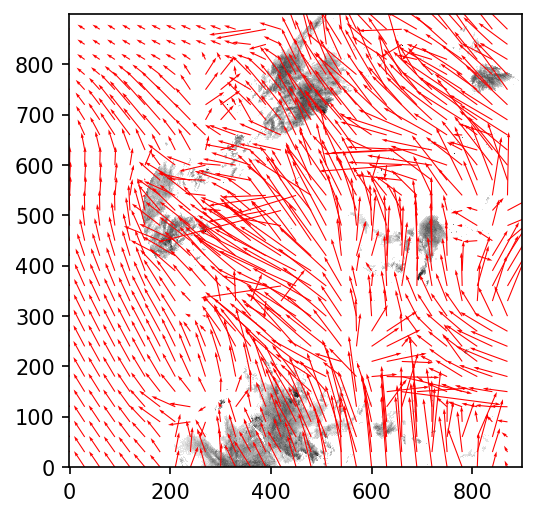

In [9]:
plt.figure(dpi = 150)
plt.imshow(data_scaled[-1], cmap = "gray_r",origin = "lower")
X,Y = range(900),range(900)
skip = 30
plt.quiver(X[::skip], Y[::skip], delta[:,:,0][::skip,::skip], delta[:,:,1][::skip,::skip],
           scale = 30,color='red',headwidth = 3)
plt.show()

## ground truth

In [54]:
import datetime,imageio
images = []
minute = 0
for image in data_scaled:
    plt.figure(dpi=150)
    plt.imshow(image,cmap = "gray_r",origin = "lower")
    filename = f"rainymotion_GT-{minute}min.png"
    plt.title(filename)
    plt.savefig(filename,format="png")
    plt.close()
    images.append(imageio.imread(filename))
    minute +=5
output_file = 'rainymotion_GT-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
imageio.mimsave(output_file, images,duration = 0.2)  # unit is in seconds

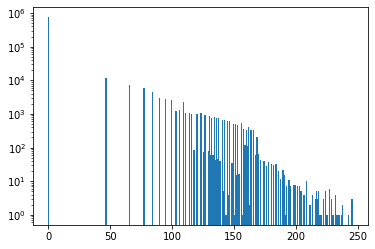

In [8]:
plt.hist(data_scaled[0].ravel(),256)
plt.yscale('log')